In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import random

# Loading the Data
training_df = pd.read_csv('data/optdigits.tra', header=None)
X_training, y_training = training_df.loc[:, 0:63], training_df.loc[:, 64]
X_training.head()

testing_df = pd.read_csv('data/optdigits.tes', header=None)
X_testing, y_testing = testing_df.loc[:, 0:63], testing_df.loc[:, 64]

In [2]:
class Layer():
    
    ACTIVATION_FUNCS = {
        'none': lambda x: x,
        'relu': lambda x: max(0, x),
        'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
        'round': np.around
    }
    ACTIVATION_FUNCS_DERIVATIVES = {
        'none': lambda x: 1,
        'relu': lambda x: 0 if x <= 0 else 1,
        'sigmoid': lambda x: Layer.ACTIVATION_FUNCS['sigmoid'](x) * (1 - Layer.ACTIVATION_FUNCS['sigmoid'](x)),
        'round': lambda x: 1
    }
    
    def __init__(self, no_of_neurons, activation_function):
        self.no_of_neurons = no_of_neurons
        self.activation_func = activation_function
        self.cached_outputs = np.zeros((self.no_of_neurons,))
        
    def init_weights_array(self, no_of_previous_layer_neurons):
        # Initialize the weights and biases randomly in the range [-1, 1]
        
        self.weights = 2 * np.random.rand(self.no_of_neurons, no_of_previous_layer_neurons) - 1
        self.biases = 2 * np.random.rand(self.no_of_neurons) - 1
        self.clear_errors()
        
    def clear_errors(self):
        # This method clears the cached gradients and derivatives
        
        self.gradients = np.zeros((self.no_of_neurons, self.weights.shape[1]))
        self.derivatives = np.zeros((self.no_of_neurons,))
        
    def get_outputs(self, previous_layer_outputs):
        outputs = np.zeros((self.no_of_neurons,))
        for neuron_idx in range(self.no_of_neurons):
            activation_input = np.dot(self.weights[neuron_idx], previous_layer_outputs) + self.biases[neuron_idx]
            neuron_output = Layer.ACTIVATION_FUNCS[self.activation_func](activation_input)
            outputs[neuron_idx] = neuron_output
        self.cached_outputs = outputs
        return outputs
        
    def accumulate_error(self, neuron_derivatives, previous_layer_outputs):
        # This method accumulates the gradients and derivatives for this layer (accumulation is done to support batching).
        # neuron_derivatives = Derivatives coming from the next layer to allow utilization of chain rule
        # previous_layer_outputs = Outputs from the previous layer to calculate gradients of this layer
        
        prev_layer_derivatives = np.zeros((previous_layer_outputs.shape[0],))
        activation_func_derivatives = np.vectorize(Layer.ACTIVATION_FUNCS_DERIVATIVES[self.activation_func])(self.cached_outputs)  # Derivatives of the activation functions in this layer
        for neuron_idx in range(self.no_of_neurons):  # Calculate gradients and derivatives for each neuron
            activation_func_derivative = activation_func_derivatives[neuron_idx]  # Derivative of the activation function
            gradient = activation_func_derivative * neuron_derivatives[neuron_idx] * previous_layer_outputs  # Gradients (errors) of the weights, calculated by applying chain rule
            self.gradients[neuron_idx] += gradient  # Cache gradients
            self.derivatives[neuron_idx] += activation_func_derivative * neuron_derivatives[neuron_idx]  # Cache derivatives
            
            for prev_layer_neuron_idx in range(previous_layer_outputs.shape[0]):  # Calculate the chain derivative for previous layer neurons
                prev_layer_derivatives[prev_layer_neuron_idx] += activation_func_derivative * self.weights[neuron_idx][prev_layer_neuron_idx] * neuron_derivatives[neuron_idx]
        
        return prev_layer_derivatives
            
class InputLayer(Layer):
    def __init__(self, input_size):
        super().__init__(input_size, "none")
        
    def init_weights_array(self):
        # All weights must be 1, all biases must be 0 since this is the input layer 
        
        self.weights = np.ones((self.no_of_neurons,))
        self.biases = np.zeros((self.no_of_neurons,))
            
class NeuralNetwork:
    
    ERROR_FUNCTIONS = {
        "mse": lambda y, yhat: 0.5 * (y - yhat) ** 2
    }
    ERROR_FUNCTIONS_DERIVATIVES = {
        "mse": lambda y, yhat: yhat - y
    }
    
    def __init__(self, layers, error_function="mse"):
        self.layers = layers
        self.error_function = error_function
        self.layers[0].init_weights_array()  # This is done separately since input layer's init weight method's signature is different
        for i in range(1, len(layers)):
            self.layers[i].init_weights_array(self.layers[i - 1].no_of_neurons)  # Initialize the weights and biases of the layers
    
    def update_parameters(self, learning_rate):
        # This method is responsible for updating the weights and biases at each layer by taking their errors (gradients and derivatives) into account
        
        for i in range(len(self.layers) - 1, 0, -1):
            self.layers[i].weights -= learning_rate * self.layers[i].gradients
            self.layers[i].biases -= learning_rate * self.layers[i].derivatives
            self.layers[i].clear_errors()
                    
    def predict(self, X):
        # Returns the output of the network as the result of given input X.
        
        last_outputs = X
        self.layers[0].cached_outputs = X
        for i in range(1, len(self.layers)):
            last_outputs = self.layers[i].get_outputs(last_outputs)
        return last_outputs
    
    def train(self, X, y, learning_rate = 1e-06, batch_size=1):
        # Trains the neural network using given samples and their corresponding labels
        
        iter_no = 0
        for idx in range(len(X)):  # For each given sample
            iter_no += 1
            
            x_sample = X[idx]
            y_sample = y[idx]
            yhat = self.predict(x_sample)  # First, apply forward propagation
            derivatives = NeuralNetwork.ERROR_FUNCTIONS_DERIVATIVES[self.error_function](y_sample, yhat)  # This is the derivative of the output layer (e.g. mean square error of each output neuron)
            for i in range(len(self.layers) - 1, 0, -1):  # Apply back propagation
                derivatives = self.layers[i].accumulate_error(derivatives, self.layers[i - 1].cached_outputs)
                
            if iter_no == batch_size:  # If batch size is reached, update the parameters
                self.update_parameters(learning_rate)
                iter_no = 0
                
        self.update_parameters(learning_rate)  # Be sure to make the final update if batch size is not evenly divisible by train data size

In [3]:
EPOCH_COUNT = 20
BATCH_SIZE = 8

autoencoder = NeuralNetwork([InputLayer(64), Layer(2, "none"), Layer(64, "round")])
train_losses = []
test_losses = []
for epoch_idx in range(EPOCH_COUNT):
    autoencoder.train(X_training.values, X_training.values, learning_rate=1e-06, batch_size=BATCH_SIZE)
    
    train_loss = 0
    for train_X in X_training.values:
        train_loss += np.sum(np.square(train_X - autoencoder.predict(train_X)))
    train_loss /= len(X_training)
    train_losses.append(train_loss)
    
    test_loss = 0
    for test_X in X_testing.values:
        test_loss += np.sum(np.square(test_X - autoencoder.predict(test_X)))
    test_loss /= len(X_testing)
    test_losses.append(test_loss)
    print(f"EPOCH #{epoch_idx + 1} | Train Loss: {train_loss} | Test Loss: {test_loss}")

EPOCH #1 | Train Loss: 4532.601621763013 | Test Loss: 4536.7740678909295
EPOCH #2 | Train Loss: 3214.296364111954 | Test Loss: 3222.5765164162494
EPOCH #3 | Train Loss: 1663.4363065655245 | Test Loss: 1682.2493043962158
EPOCH #4 | Train Loss: 1319.4737117447032 | Test Loss: 1334.3166388425152
EPOCH #5 | Train Loss: 1263.9636411195397 | Test Loss: 1275.2776850306066
EPOCH #6 | Train Loss: 1238.4096259482083 | Test Loss: 1246.6388425153034
EPOCH #7 | Train Loss: 1221.8127125294272 | Test Loss: 1229.3238731218698
EPOCH #8 | Train Loss: 1209.5668323306304 | Test Loss: 1216.7011686143574
EPOCH #9 | Train Loss: 1200.0633010724562 | Test Loss: 1206.1825264329439
EPOCH #10 | Train Loss: 1192.541459586712 | Test Loss: 1197.9198664440735
EPOCH #11 | Train Loss: 1186.3434475542767 | Test Loss: 1191.31775180857
EPOCH #12 | Train Loss: 1181.0005231493592 | Test Loss: 1185.3689482470784
EPOCH #13 | Train Loss: 1175.8911849332985 | Test Loss: 1179.399554813578
EPOCH #14 | Train Loss: 1171.12686371959

Text(0, 0.5, 'Mean Square Error')

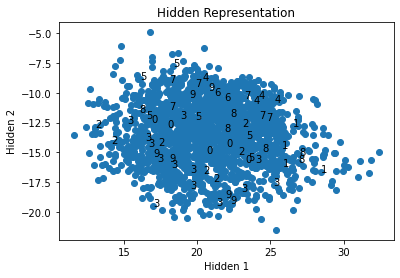

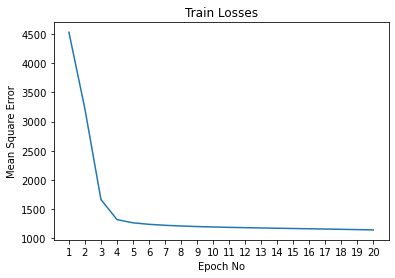

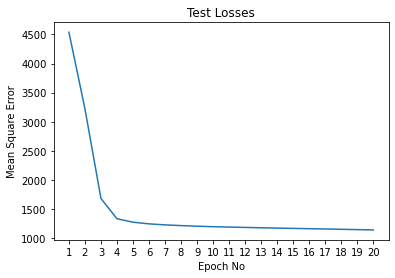

In [4]:
reduced_representations = []  # Reduced representations for test samples (they are with dimension 2)
for test_idx in range(len(X_testing)):
    test_X = X_testing.values[test_idx]
    test_y = y_testing.values[test_idx]
    
    autoencoder.predict(test_X)
    reduced_representations.append((test_y, autoencoder.layers[1].cached_outputs))

point_count = 0  # To limit the digits annotated in the plot
pyplot.figure()
pyplot.scatter([x[0] for _, x in reduced_representations], [x[1] for _, x in reduced_representations])
for digit, xy in reduced_representations:
    point_count += 1
    if point_count % 30 == 0:
        pyplot.annotate(str(digit), (xy[0], xy[1]), (xy[0], xy[1]))
pyplot.title("Hidden Representation")
pyplot.xlabel("Hidden 1")
pyplot.ylabel("Hidden 2")

pyplot.figure()
pyplot.plot([*range(1, EPOCH_COUNT + 1)], train_losses)
pyplot.xticks([*range(1, EPOCH_COUNT + 1)])
pyplot.title("Train Losses")
pyplot.xlabel("Epoch No")
pyplot.ylabel("Mean Square Error")

pyplot.figure()
pyplot.plot([*range(1, EPOCH_COUNT + 1)], test_losses)
pyplot.xticks([*range(1, EPOCH_COUNT + 1)])
pyplot.title("Test Losses")
pyplot.xlabel("Epoch No")
pyplot.ylabel("Mean Square Error")

## Report

In this homework, I implemented a generic artificial neural network and layer classes, and created an autoencoder instance by giving input samples also as labels. It behaves as a dimension reducer, with hidden layer's output becoming the reduced vector. 


Optdigits dataset is used, dimension for each input sample is 64, and there is a label indicating the digit of the sample. Reduced vectors (with dimension 2) are plotted above with their digit labels. It can be seen that same digits are close in the space, implying that our autoencoder works as expected. I did not use any activation function in the hidden layer, since this gave the best results among my trials.

I utilized an epoch approach, since going through the entire dataset for many times improves the accuracy drastically. I gave a large number (20) to be sure that it converged and yielded the best results. I also set the batch size to 32, since it is usually the best number to specify. Lastly, learning rate is specifically set to 1e-06 to avoid exploding gradient and non-convergence (underfit) problems.

Also, train and test losses (mean square errors) turned out to be similar. This is because samples' values are not so high (in the range 0-16) for both train and test datasets, which does not create a huge difference.